In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
%matplotlib inline

In [3]:
#dataloading
dataset=pd.read_excel('Final_april_22_24.xlsx')
dataset.head()

,PlantID,RWC,Emm_04222024,gsw_04222024,PhiPS2_04222024,ETR_04222024,503,506,508,511,...,967,970,972,975,978,981,983,986,989,992
0,111,89.086788,0.745927,0.052967,0.073338,46.369003,0.030382,0.036214,0.043078,0.051798,...,0.544259,0.537924,0.524810,0.518818,0.519179,0.515159,0.509742,0.500198,0.490246,0.478974
1,112,89.576174,1.556236,0.119527,0.047671,30.140169,0.152773,0.160788,0.171934,0.179236,...,0.497954,0.489364,0.471756,0.463006,0.462499,0.460909,0.455054,0.447277,0.442703,0.431510
2,113,92.377771,0.502678,0.036583,0.058134,36.754659,0.086789,0.092778,0.100661,0.108757,...,0.591370,0.585382,0.574023,0.569221,0.570507,0.568442,0.564118,0.555738,0.545801,0.536428
3,114,90.903522,0.331857,0.024247,0.049890,31.542745,0.002133,0.006886,0.013747,0.021409,...,0.526540,0.519642,0.508035,0.501883,0.502461,0.499594,0.494314,0.484216,0.472529,0.462194
4,115,89.638009,0.547557,0.036947,0.128774,81.418136,0.030182,0.035466,0.043540,0.051189,...,0.574955,0.567958,0.556971,0.551251,0.553832,0.550637,0.546324,0.535134,0.521055,0.510470


Ground truth: (97, 5), Reflectance: (97, 181)


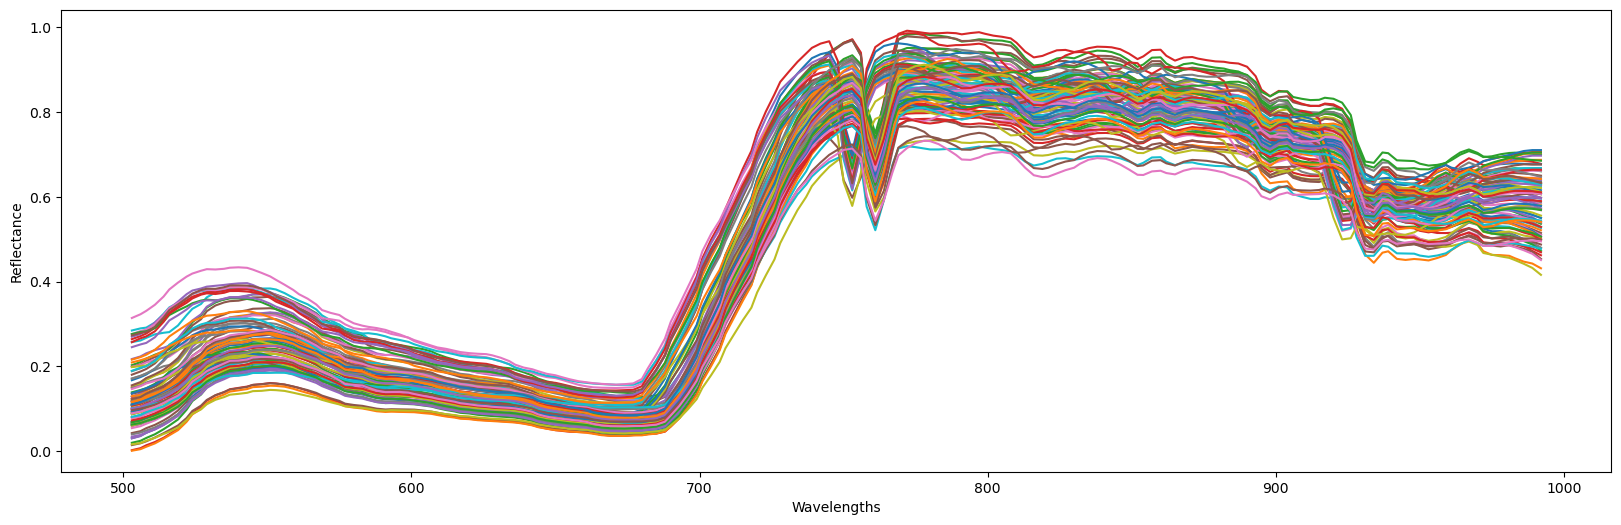

In [5]:
#visualizing reflectance value
ground_truths= dataset.iloc[:,1:6]
reflectance= dataset.iloc[:,6:]

ax=reflectance.iloc[:,:].T.plot(figsize=(20,6),legend=False)
ax.set_xlabel("Wavelengths")
ax.set_ylabel('Reflectance')

print(f'Ground truth: {ground_truths.shape}, Reflectance: {reflectance.shape}')

In [22]:
#helper function for finding optimal range
def snr(spectral):
    mean_s=np.mean(spectral)
    std_s=np.std(spectral)
    return np.where(std_s==0,0,mean_s/std_s)

def find_range(spectral,wavelengths,win):
    n=spectral.shape[0]
    snr_value=np.zeros(n-win+1)
    for i in range(n-win+1):
        snr_value[i]=snr(spectral[i:i+win])
        
    optimal_start=wavelengths[np.argmax(snr_value)]
    optimal_end=optimal_start+win
    return optimal_start, optimal_end,max(snr_value)



def optimum_range(win_size,dataframe):
    dic={'s':[],'e':[],'v':[]}
    for i in range(dataframe.shape[0]):
        
        s,e,v=find_range(dataframe.iloc[i,:],dataframe.columns.values.astype('int'),win_size)
        dic['s'].append(s)
        dic['e'].append(e)
        dic['v'].append(v)
    df=pd.DataFrame.from_dict(dic).describe()
 
    print(f'For window size {win_size}\n min start and end {df.iloc[3,0:2].values} with SNR {df.iloc[3,2]} \n max start and end {df.iloc[-1,0:2].values} \n............\n')

def viz(value,title):
    '''
    Dataset visualization
    '''
    ax=value.T.plot(figsize=(20,6),legend=False)
    ax.set_xlabel("Wavelengths")
    ax.set_ylabel('Reflectance')
    ax.set_title(title)    


In [9]:
#defining window size
win_size=[reflectance.shape[1],reflectance.shape[1]-20,reflectance.shape[1]-50]
win_size

[181, 161, 131]

In [13]:
for i in win_size:
    optimum_range(i,reflectance)

For window size 181
 min start and end [503. 684.] with SNR 1.3794243542023117 
 max start and end [503. 684.] 
............

For window size 161
 min start and end [556. 717.] with SNR 1.5442566244566578 
 max start and end [556. 717.] 
............

For window size 131
 min start and end [636. 767.] with SNR 2.018505522886981 
 max start and end [636. 767.] 
............



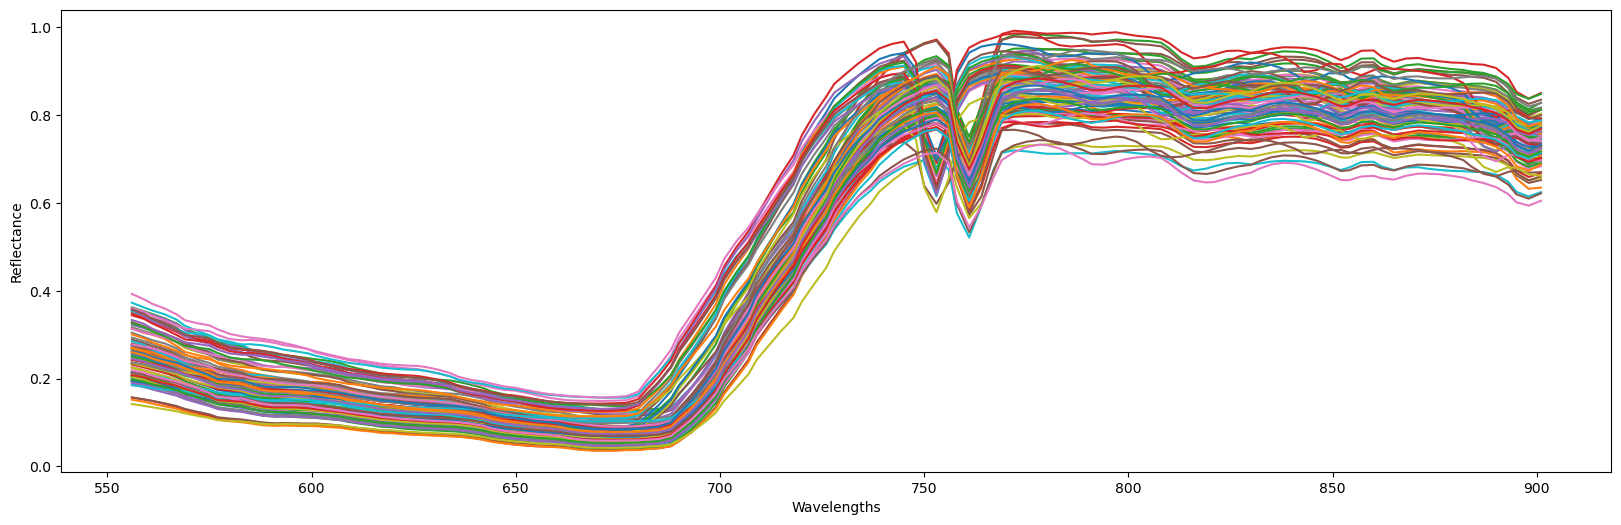

In [21]:
viz(reflectance.loc[:,556.: 901.],'')

## Preprocessing

1. log(1/r) transformation- absorbance
2. mean scatter correction 
3. mean- center scaling - SNV

In [23]:
def transformation(r):
    return np.log(1/r)

def mean_center(data):
    new=data.copy()
    for i in range(data.shape[0]):
         new.iloc[i,:]= (data.iloc[i,:]-np.mean(data.iloc[i,:]))
    return new
        
def msc(input_data,reference=None):
    eps=np.finfo(np.float32).eps
    input_=np.array(input_data,dtype=np.float64)
    ref=[]
    sampleCount=int(len(input_))
    for i in range(input_data.shape[0]):
        input_[i,:]-=input_[i,:].mean()
    data_msc=input_data.copy()
    for i in range(input_.shape[0]):
        for j in range(0,sampleCount,10):
            ref.append(np.mean(input_[j:j+10],axis=0))
            fit=np.polyfit(ref[i],input_[i,:],1,full=True)
            data_msc.iloc[i,:]=(input_[i,:]-fit[0][1])/fit[0][0]
    
    return (data_msc)

In [25]:
x_1=transformation(reflectance)
x_2=msc(x_1)
x_3=mean_center(x_2)


Text(0.5, 1.0, 'preprocessed')

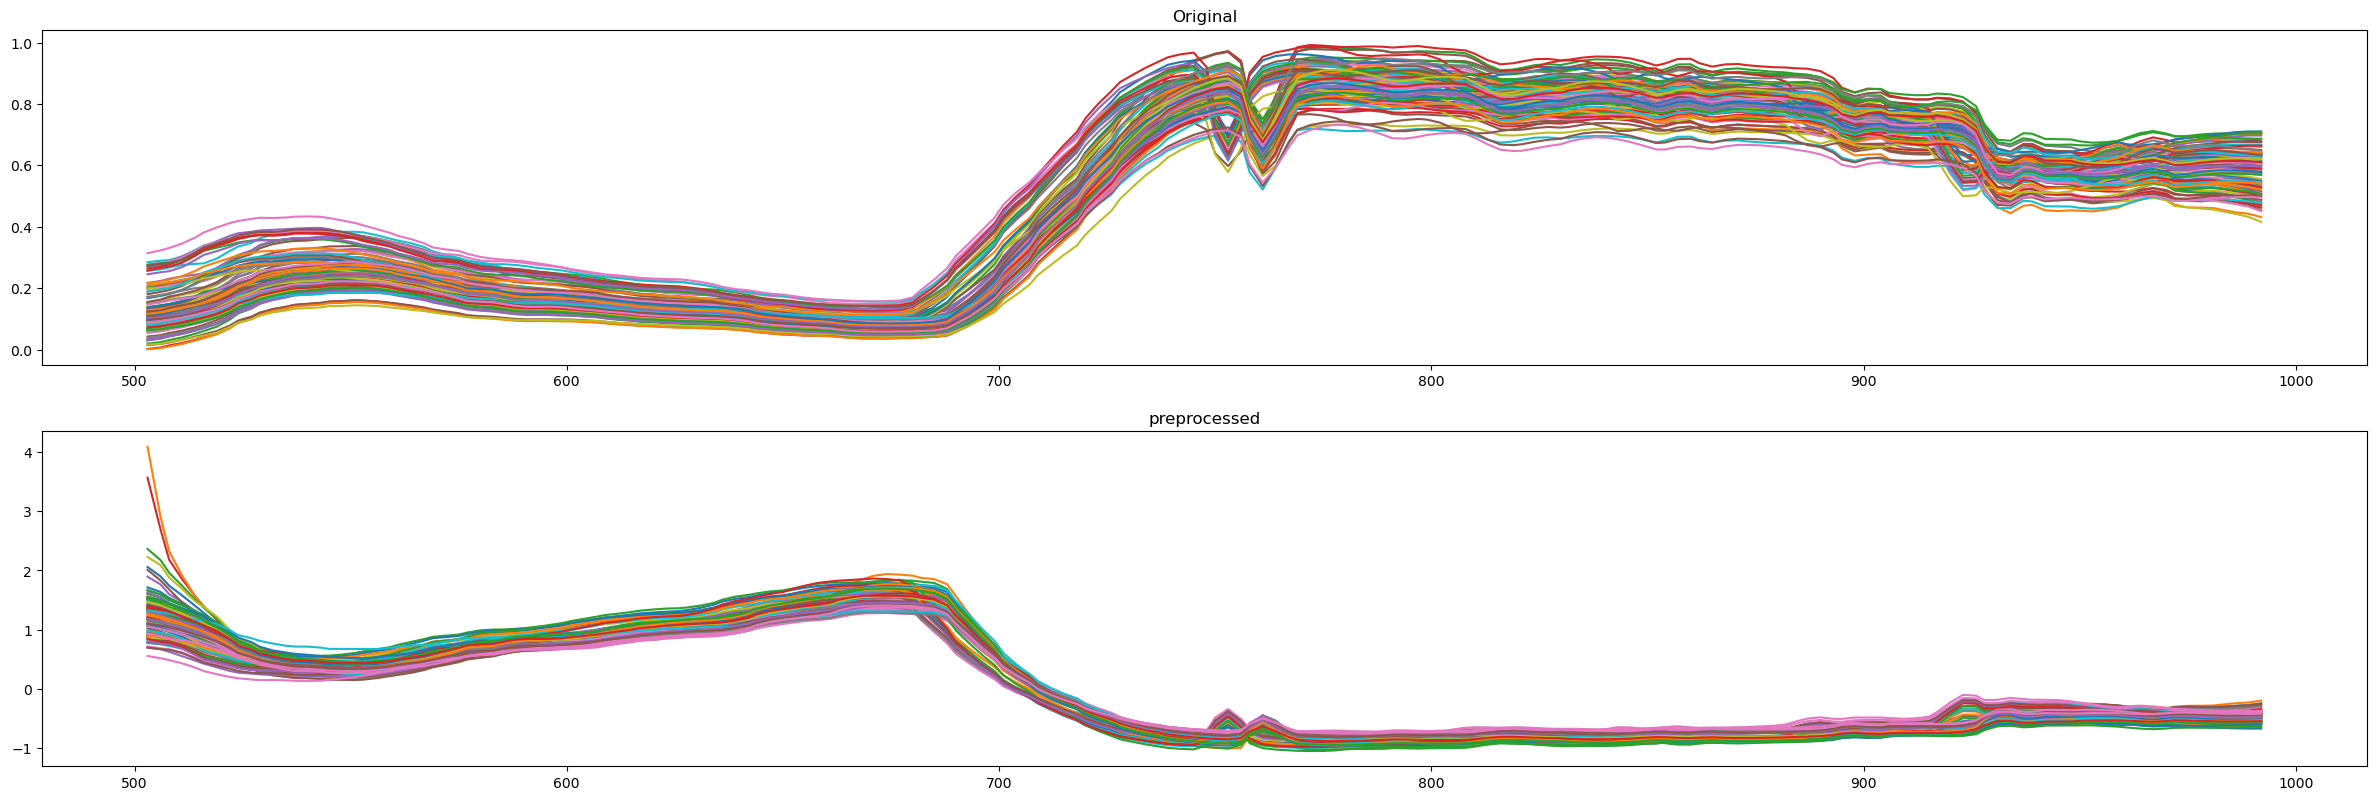

In [27]:
plt.figure(figsize=(30,20))

ax1 = plt.subplot(411)
reflectance.T.plot(ax=ax1,legend=False)
ax1.set_title('Original')
    
ax2=plt.subplot(412)
x_3.T.plot(ax=ax2,legend=False)
ax2.set_title('preprocessed')

In [42]:

standardGT = ground_truths.copy()

X1_train, X1_test, y1_train, y1_test = train_test_split(x_3, standardGT, test_size=0.2, random_state=42)


def caliberate(ytrain,ytest):
    '''
    input: target value of train and test
    
    output: standardized train and test 
    '''
    s={}
    target_col=ytrain.columns
    for col in target_col:
        s[col]=StandardScaler()
        ytrain.loc[:,col]=s[col].fit_transform(ytrain.loc[:,col].values.reshape(-1,1))
        ytest.loc[:,col]=s[col].transform(ytest.loc[:,col].values.reshape(-1,1))
    return s,ytrain,ytest

scalers_1,y1_train, y1_test=caliberate(y1_train, y1_test)

In [43]:
def rpd(true,pred):
    deviation= pred-true
    ration =(true/pred) *100
    
    return ratio, deviation

In [76]:
def visualization(ytrain,y_cv,y_test,pred,cv_rms,cv_rs,pre_rms,pre_rs,scalers):
    
    plt.figure(figsize=(60,30))

    
    for i,val in enumerate(y_cv.keys()):
        if i==12:
            break
        #transforming to original value
        cv=scalers[val].inverse_transform(y_cv[val].reshape(-1,1))
        y1=scalers[val].inverse_transform(ytrain[val].values.reshape(-1,1))
        y1_t=scalers[val].inverse_transform(y_test[val].values.reshape(-1,1))
        pre=scalers[val].inverse_transform(pred[val].reshape(-1,1))
        
        z=np.polyfit(y1.reshape(-1),cv,1)
        plt.subplot(3,4,i+1)
        plt.plot(y1,z[1]+z[0]*y1,c='dimgray',linewidth=1)
        
        plt.scatter(y1,cv, c='mediumblue', label='CV: rmse={:0.3f} & r^2={:0.3f}'.format(cv_rms[val],cv_rs[val]))

#         plt.scatter(y1_t,pre, c='coral',label='Pred: rmse={:0.3f} & r^2={:0.3f}'.format(pre_rms[val],pre_rs[val]),
#                      edgecolors='purple')
        plt.xlabel(f"True {val}")
        plt.ylabel(f"Predicted {val}")
        plt.legend(loc=0,shadow=True,handletextpad=0.3,borderpad=0.3,handlelength=1)
    plt.show()
    
def pred(model,dfx,y):
    scores_rmse={}
    scores_rs={}
    pred={}
#     if type(dfx)=='pandas.core.frame.DataFrame':
#         x=dfx.values
#     else:
#         x=dfx
    for target in y.columns:
        pred[target]=model[target].predict(dfx)
        scores_rmse[target]=mean_squared_error(y[target].values,pred[target],squared=False)
        scores_rs[target]=model[target].score(dfx,y[target])
    if 'combine' in model.keys():
        pred['combine']=model['combine'].predict(dfx)
        scores_rmse['combine']=mean_squared_error(y,pred['combine'],squared=False)
        scores_rs['combine']=model['combine'].score(dfx,y)
    return scores_rmse,scores_rs,pred    

In [45]:
def find_com(n_com,X,y):
    mse=[]
    comp=np.arange(1,n_com)
    for i in comp:
        pls=PLSRegression(n_components=i)
        y_cv=cross_val_predict(pls,X,y,cv=5)
        mse.append(mean_squared_error(y,y_cv,squared=False))

    return np.argmin(mse)

def PLSR(dfx,dftarget,component):
    scores_rmse={}
    scores_rs={}
    pred={}
    models={}
    compo=[]
    x=dfx.values
    for target in dftarget.columns:
        com=find_com(component,dfx.values,dftarget[target])
        print(f'For {target} the optimum component is {com+1} \n')
        models[target]=PLSRegression(n_components=com+1)
        models[target].fit(x,dftarget[target])
        
        pred[target]=cross_val_predict(models[target],x,dftarget[target],cv=5)
        #pred[target]=models[target].predict(x)
        scores_rmse[target]=mean_squared_error(dftarget[target].values, pred[target],squared=False)
        scores_rs[target]= models[target].score(x,dftarget[target])
        
#     com=find_com(component,dfx.values,dftarget)
#     print(f'For combine the optimum component is {com+1} \n')
#     models['combine']=PLSRegression(n_components=com+1)
#     models['combine'].fit(x,dftarget.values)
#     pred['combine']= cross_val_predict(models[target],x,dftarget.values,cv=5)
#     scores_rmse['combine']=mean_squared_error(dftarget.values, pred['combine'],squared=False)
#     scores_rs['combine']=models['combine'].score(x,dftarget)
    return scores_rmse,scores_rs,pred,models

In [77]:
PLSCvScoreRmse1951,PLSCvRs1951,PLSPreCv1951,PLSModels1951=PLSR(X1_train,y1_train,20)


For RWC the optimum component is 6 

For Emm_04222024 the optimum component is 1 

For gsw_04222024 the optimum component is 1 

For PhiPS2_04222024 the optimum component is 1 

For ETR_04222024 the optimum component is 1 



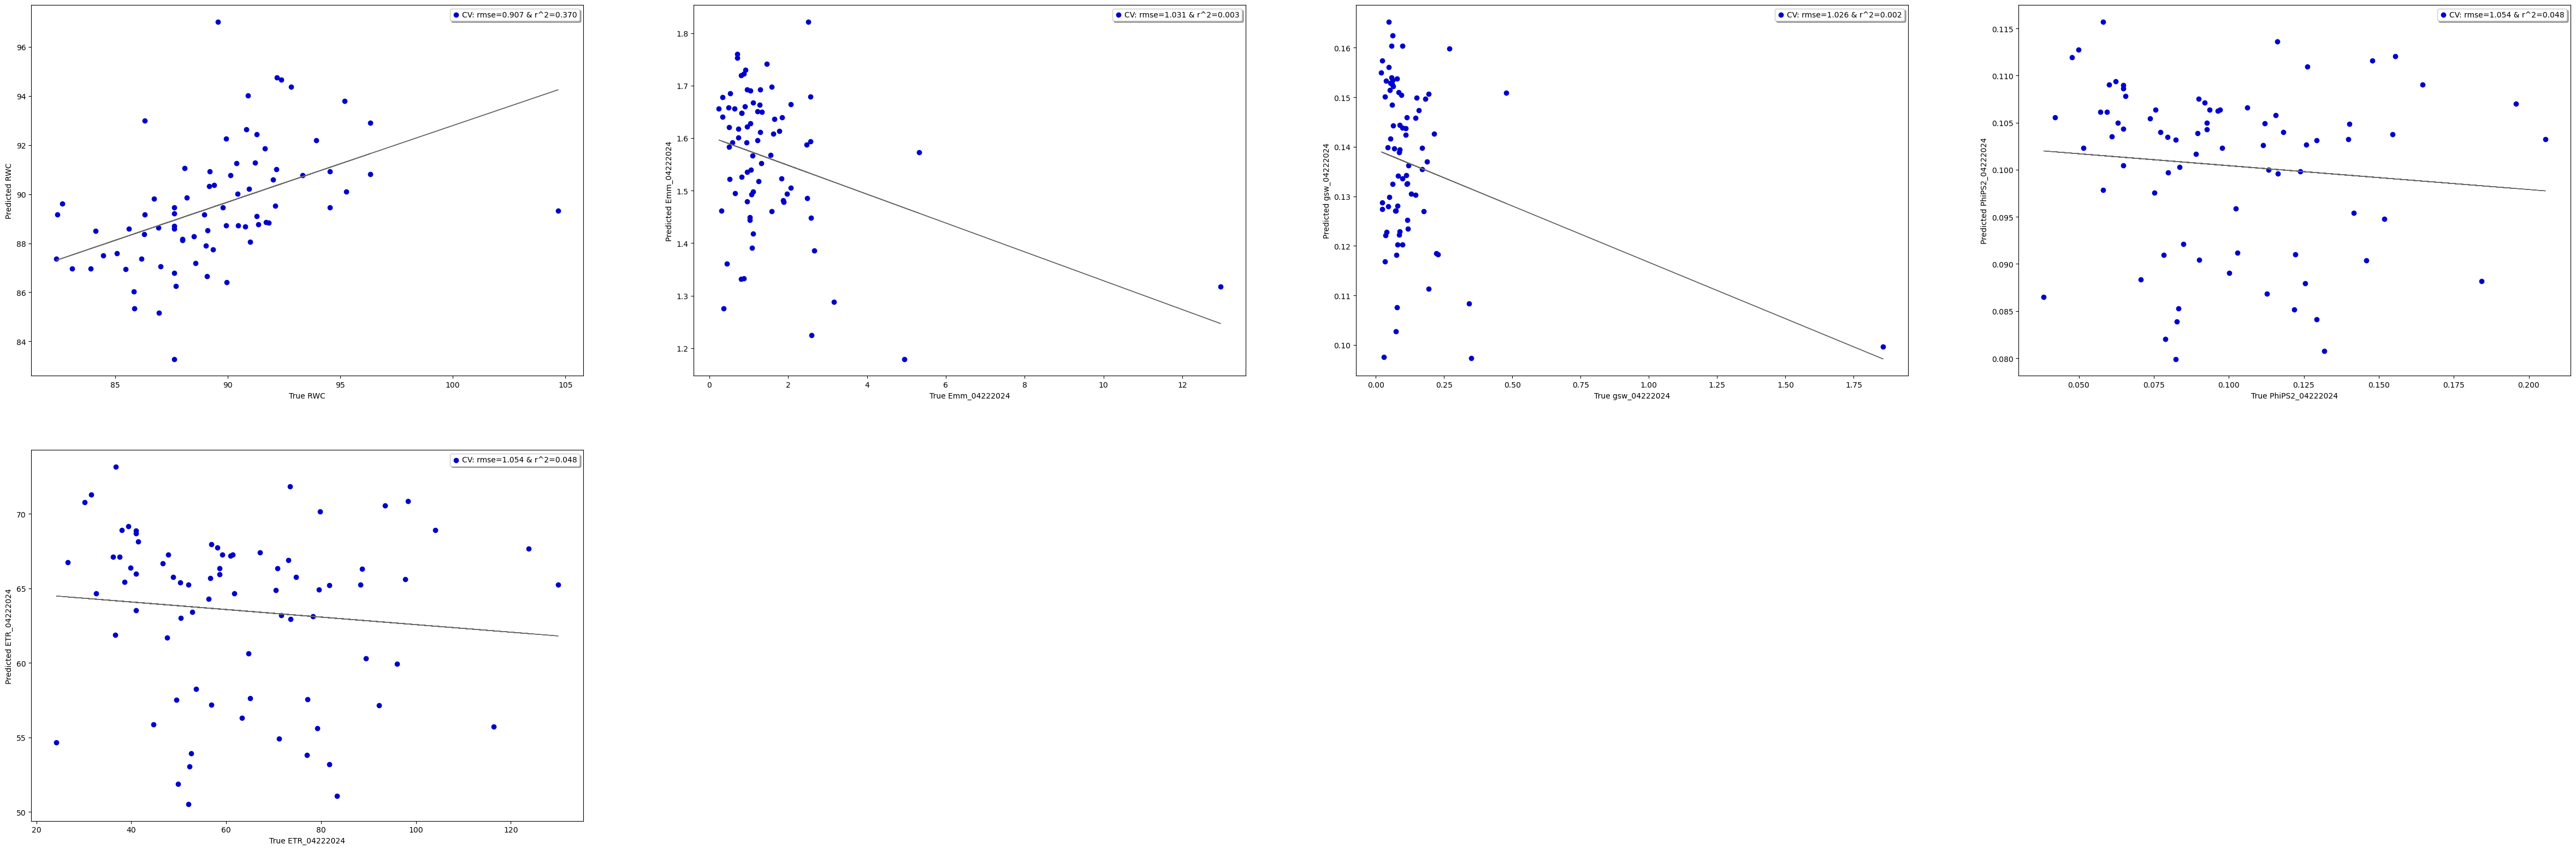

In [78]:
PLSPreScoreRmse1951,PLSPreScoreRs1951,PLSPred1951=pred(PLSModels1951,X1_test,y1_test)



visualization(y1_train,PLSPreCv1951,y1_test,PLSPred1951,
              PLSCvScoreRmse1951,PLSCvRs1951,
              PLSPreScoreRmse1951,PLSPreScoreRs1951,scalers_1)

In [85]:
PLSCvRs1951

{'RWC': 0.3700472210247364,
 'Emm_04222024': 0.003469665136718425,
 'gsw_04222024': 0.002189187618321209,
 'PhiPS2_04222024': 0.0480530186976309,
 'ETR_04222024': 0.04805383009799813}

In [133]:
x['pppp']=0

TypeError: list indices must be integers or slices, not str

In [44]:
!pip install xgboost

   ---------------------------------------- 99.8/99.8 MB 29.7 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

class SpectralAnalysis:
    '''
    Steps
    
    1. Read the Excel file.
    2. Separate columns for ground truths and reflectance data.
    3.Preprocess the reflectance data using:
        a. Log transformation
        b. Mean scatter correction
        c. Mean-center scaling
    4. Split the dataset into training and testing sets with a 20% test size.
    5. Standardize each ground truth column using a StandardScaler, fitting on the training set and transforming both training and test sets.
    6. Build a PLSR model:
        a. Find the optimum number of components
        b. Train the model using 5-fold cross-validation
        c.Store RMSE and R^2 values for each target during training and cross-validation
    7. Prediction function that computes RMSE, R^2, and prediction values.
    8. Visualization function to plot true and predicted y values from cross-validation and predictions, showing RMSE and R^2.
    
    '''
    
    def __init__(self, filepath: str(), model_type: str() ):
        self.model_type = model_type
        self.data = pd.read_excel(filepath)
        self.models = {}
        self.cv_results = {}
        # parameters
        self.split_ratio = 0.3
        self.random_state=42
        self.cv= 10
    
   
    
    def preprocess_data(self):
        self.ground_truths = self.data.iloc[:, 1:6] #ground truth
        self.reflectance = self.data.iloc[:, 6:] #X truth
        #different approach
        
#         reflectance_log = np.log(self.reflectance + 1)
#         reflectance_mean = reflectance_log.mean(axis=1)
#         reflectance_msc = reflectance_log.divide(reflectance_mean, axis=0)
#         self.reflectance_centered = reflectance_msc - reflectance_msc.mean()


        #previous approach
        reflectance_log = np.log(1/self.reflectance) #log(1/r) transformation\
        
        reflectance_msc = self.msc(reflectance_log)
        self.reflectance_centered  = self.mean_center(reflectance_msc)
        
        filtered_data = savgol_filter(self.reflectance_centered , 17, polyorder = 2,deriv=2)
        self.reflectance_centered = pd.DataFrame(filtered_data, columns=self.reflectance.columns)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.reflectance_centered, self.ground_truths, test_size=self.split_ratio, random_state= self.random_state
        )
        
        self.scalers = {}
        for column in self.ground_truths.columns:
            scaler = StandardScaler()
            self.y_train[column] = scaler.fit_transform(self.y_train[[column]])
            self.y_test[column] = scaler.transform(self.y_test[[column]])
            self.scalers[column] = scaler
            
    def fit_model(self):
        print("Model type:", self.model_type)
        if self.model_type == 'PLSR':
            self.Model_PLSR()
        elif self.model_type == 'SVR':
            self.model_svr()
        elif self.model_type == 'RF':
           
            self.model_random_forest()
        elif self.model_type == 'XGBoost':
            # Placeholder for XGBoost
            pass
        elif self.model_type == 'MLP':
            # Placeholder for MLP
            pass
        else: 
            print('No model selected')

    def Model_PLSR(self, max_components=6):
        print('Here')
        for idx, target in enumerate(self.y_train.columns):
            min_rmse = float('inf')
            best_n_components = 1
            for n_components in range(1, min(max_components, self.X_train.shape[1]) + 1):
                pls = PLSRegression(n_components=n_components)
                y_cv = cross_val_predict(pls, self.X_train, self.y_train[target], cv=self.cv)
                rmse = np.sqrt(mean_squared_error(self.y_train[target], y_cv))
                r2 = r2_score(self.y_train[target], y_cv)
                if rmse < min_rmse:
                    min_rmse = rmse
                    best_n_components = n_components
                    self.cv_results[target] = {'RMSE': rmse, 'R2': r2}
            best_pls = PLSRegression(n_components=best_n_components)
            best_pls.fit(self.X_train, self.y_train[target])
            self.models[target] = best_pls
            print(f"Best number of components for {target}: {best_n_components}")

    def model_svr(self):
        
        """
        Support vector machine (regression)
        
        """
#         param_distributions = {
#             'C': [0.01, 0.1, 1, 10, 15, 100],
#             'gamma': [0.1, 0.001, 0.01, 1],
#             'kernel': ['rbf']
#         }
        param_distributions = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Expanding the range of C
            'gamma': [0.001, 0.01, 0.1, 1, 10, 'scale', 'auto'],  # Adding more options, including 'scale' and 'auto'
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Exploring different kernel types
            'epsilon': [0.01, 0.1, 0.5, 1, 2],  # Epsilon in the epsilon-SVR model
            'degree': [2, 3, 4]  # Degree of the polynomial kernel function (if 'poly' is chosen)
        }

        random_search = RandomizedSearchCV(
            estimator=SVR(),
            param_distributions=param_distributions,
            n_iter=10,
            verbose=1,
            random_state=self.random_state,
            cv=self.cv,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        for column in self.y_train.columns:
            print(f"Training SVR for {column}")
            random_search.fit(self.X_train, self.y_train[column])
            best_svr = random_search.best_estimator_
            self.models[column] = best_svr
            print(f"Best parameters for {column}: {random_search.best_params_} \n")
            print(f"Best score (MSE) for {column}: {random_search.best_score_}")
    
    def model_random_forest(self):

        """
        Random forest model

        """

        # Define the parameter grid for Random Forest
        param_distributions = {
            'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
            'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
            'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum number of levels in tree
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
            'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
            'bootstrap': [True, False]  # Method of selecting samples for training each tree
        }

        # Initialize a RandomizedSearchCV object using RandomForestRegressor as the estimator
        random_search = RandomizedSearchCV(
            estimator=RandomForestRegressor(),
            param_distributions=param_distributions,
            n_iter=10,  # Adjust based on computational budget
            cv=self.cv,  # Number of folds in cross-validation
            verbose=1,
            random_state=self.random_state,
            n_jobs=-1  # Use all available cores
        )

        # Dictionary to store the models for each target


        # Fit Random Forest model for each target
        for column in self.y_train.columns:
            print(f"Training Random Forest for {column}")
            # Conduct the random search
            random_search.fit(self.X_train, self.y_train[column])

            # Best estimator after the search
            best_rf = random_search.best_estimator_

            # Store the best model in the dictionary
            self.models[column] = best_rf

            # Optionally, print the best parameters and score
            print(f"Best parameters for {column}: {random_search.best_params_}")
            print(f"Best score for {column}: {random_search.best_score_}")
            
            
    def model_xgboost(self):
        # Define the parameter grid for XGBoost
        param_distributions = {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1, 0.3],
            'max_depth': [3, 4, 5, 6],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'subsample': [0.6, 0.8, 1.0]
        }

        # Initialize a RandomizedSearchCV object using XGBRegressor as the estimator
        random_search = RandomizedSearchCV(
            estimator=XGBRegressor(objective='reg:squarederror', random_state=self.random_state),
            param_distributions=param_distributions,
            n_iter=20,  # Adjust based on computational budget
            cv=5,  # Number of folds in cross-validation
            verbose=1,
            random_state=self.random_state,
            n_jobs=-1  # Use all available cores
        )

        # Dictionary to store the models for each target

        # Fit XGBoost model for each target
        for column in self.y_train.columns:
            print(f"Training XGBoost for {column}")
            # Conduct the random search
            random_search.fit(self.X_train, self.y_train[column])

            # Best estimator after the search
            best_xgboost = random_search.best_estimator_

            # Store the best model in the dictionary
            self.models[column] = best_xgboost

            # Optionally, print the best parameters and score
            print(f"Best parameters for {column}: {random_search.best_params_}")
            print(f"Best score for {column}: {random_search.best_score_}")
            
    def evaluate_model(self):
        results = {}
        for target, model in self.models.items():
            y_pred = model.predict(self.X_test)
            rmse = np.sqrt(mean_squared_error(self.y_test[[target]], y_pred))
            r2 =  model.score(self.X_test,self.y_test[target])  # Ensuring R2 is not negative
            results[target] = {'RMSE': rmse, 'R2': r2}
        return results

    def plot_results(self):
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
        axs = axs.flatten()
        for i, target in enumerate(self.models.keys()):
            model = self.models[target]

            # Predictions
            y_pred_scaled = model.predict(self.X_test)
 
            
            # Check for dimension
            if y_pred_scaled.ndim == 1:
                y_pred_scaled = y_pred_scaled.reshape(-1, 1)
            y_pred = self.scalers[target].inverse_transform(y_pred_scaled)
            y_true_test = self.scalers[target].inverse_transform(self.y_test[[target]])
            
            # Cross-validation
            y_cv_scaled = cross_val_predict(model, self.X_train, self.y_train[target], cv=self.cv)

            
            # Check for dimension
            if y_cv_scaled.ndim == 1:
                y_cv_scaled = y_cv_scaled.reshape(-1, 1)
                
            y_cv = self.scalers[target].inverse_transform(y_cv_scaled)
            y_true_train = self.scalers[target].inverse_transform(self.y_train[[target]])

            # RMSE and R2 for predictions
            
            rmse_pred = np.sqrt(mean_squared_error(self.y_test[target], y_pred_scaled))
            r2_pred = model.score(self.X_test,self.y_test[target]) # Ensuring R2 is not negative

            # RMSE and R2 for cross-validation

            rmse_cv = np.sqrt(mean_squared_error(self.y_train[target], y_cv_scaled))
            r2_cv = model.score(self.X_train,self.y_train[target]) # Ensuring R2 is not negative

            # Plotting
            axs[i].scatter(y_true_test, y_pred, color='red', label=f'Prediction (RMSE={rmse_pred:.2f}, R²={r2_pred:.2f})')
            axs[i].scatter(y_true_train, y_cv, color='blue', label=f'CV (RMSE={rmse_cv:.2f}, R²={r2_cv:.2f})')

            # Trend lines
            # Calculate coefficients for trend lines
            z_pred = np.polyfit(y_true_test.flatten(), y_pred.flatten(), 1)
            p_pred = np.poly1d(z_pred)
            z_cv = np.polyfit(y_true_train.flatten(), y_cv.flatten(), 1)
            p_cv = np.poly1d(z_cv)

            # Plot trend lines
            axs[i].plot(y_true_test, p_pred(y_true_test), "r--")
            axs[i].plot(y_true_train, p_cv(y_true_train), "b--")

            axs[i].set_title(f'Results for {target}')
            axs[i].set_xlabel('True Values')
            axs[i].set_ylabel('Predicted Values')
            axs[i].legend()

        plt.tight_layout()
        plt.show()
        
    def mean_center(self,value):
        """
        Preprocessing
        """
        for i in range(value.shape[0]):
             value.iloc[i,:]= (value.iloc[i,:]-np.mean(value.iloc[i,:]))
        return value

    def msc(self,value,reference=None):
        """
        Preprocessing
        """
        eps=np.finfo(np.float32).eps
        input_=np.array(value,dtype=np.float64)
        ref=[]
        sampleCount=int(len(input_))
        for i in range(value.shape[0]):
            input_[i,:]-=input_[i,:].mean()
        data_msc=value.copy()
        for i in range(input_.shape[0]):
            for j in range(0,sampleCount,10):
                ref.append(np.mean(input_[j:j+10],axis=0))
                fit=np.polyfit(ref[i],input_[i,:],1,full=True)
                data_msc.iloc[i,:]=(input_[i,:]-fit[0][1])/fit[0][0]

        return (data_msc)


ModuleNotFoundError: No module named 'xgboost'

Model type: PLSR
Here
Best number of components for RWC: 6
Best number of components for Emm_04222024: 1
Best number of components for gsw_04222024: 1
Best number of components for PhiPS2_04222024: 3
Best number of components for ETR_04222024: 3


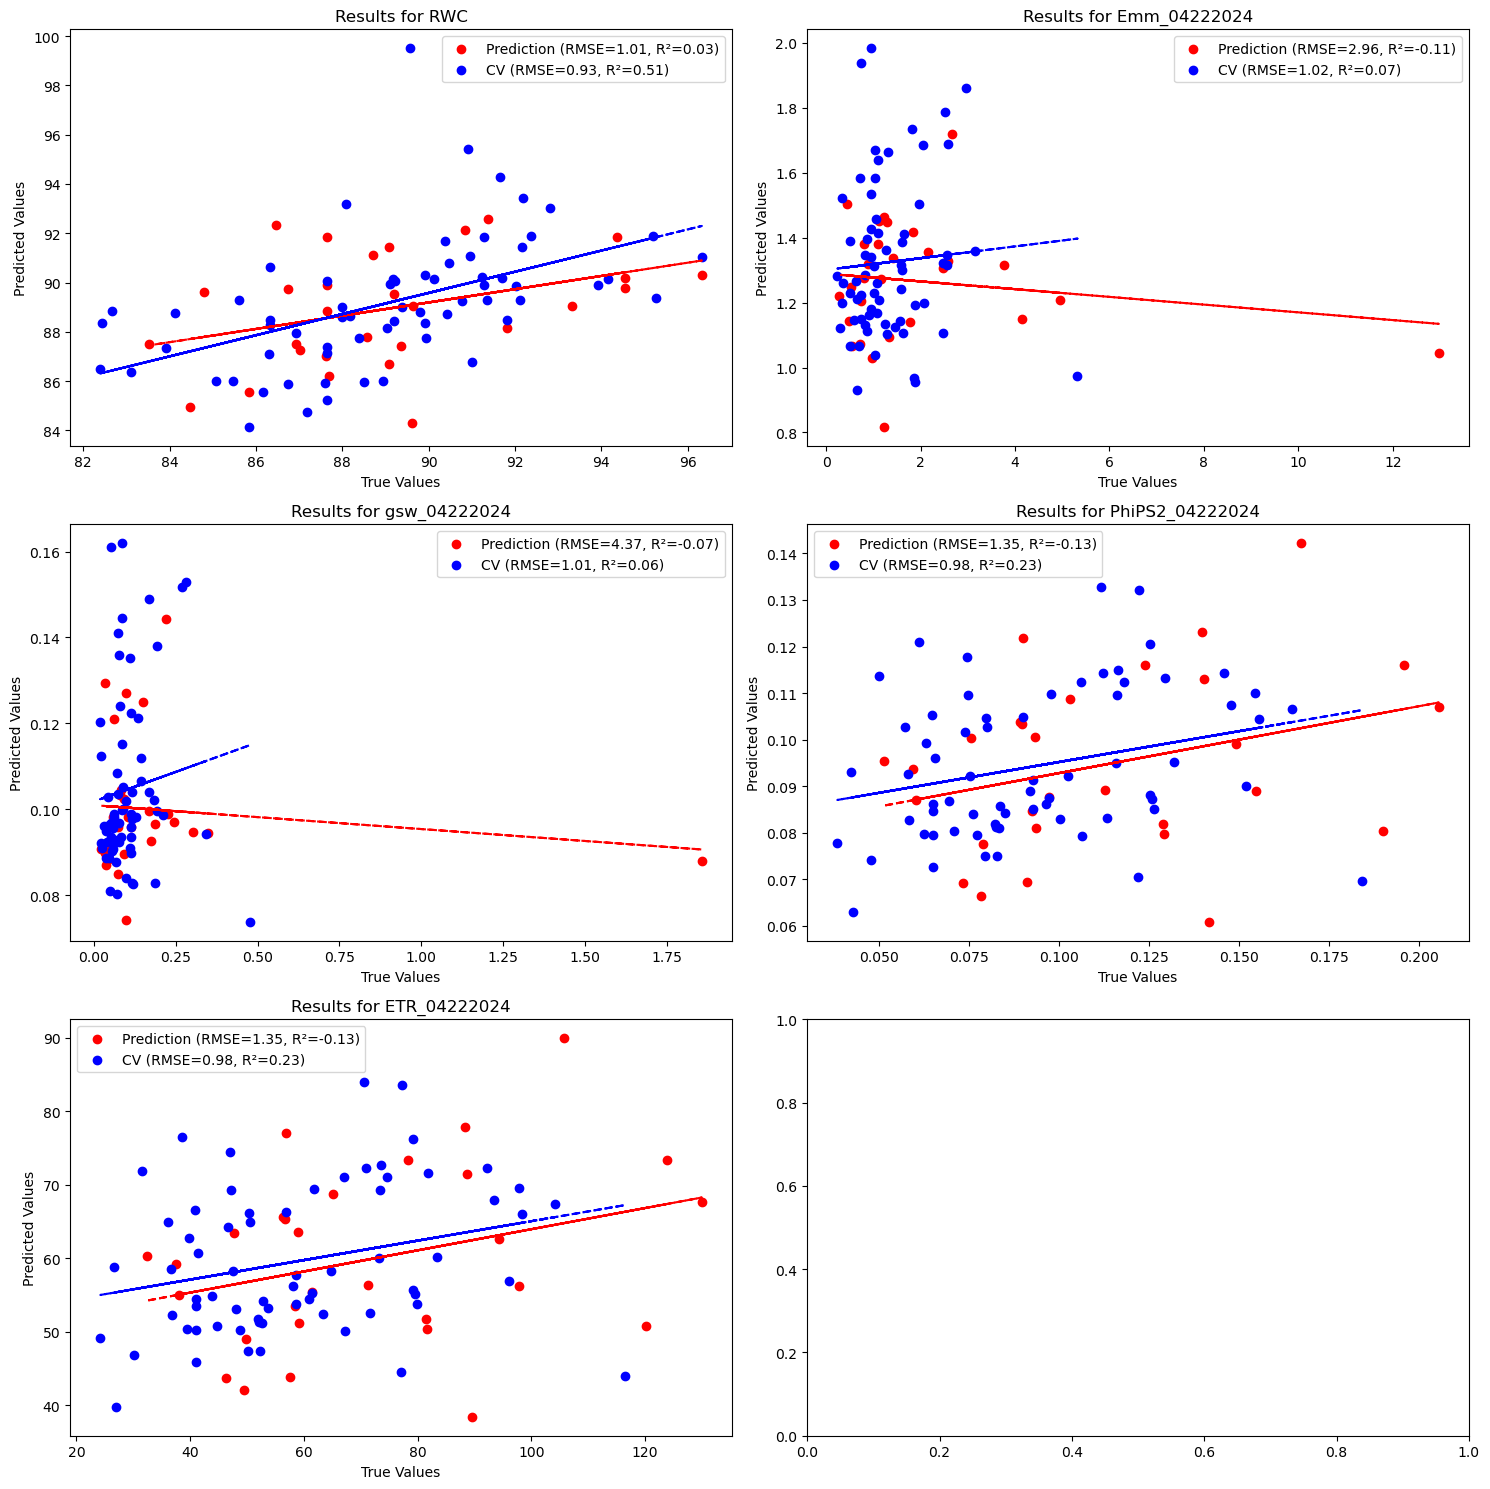

In [37]:

# Usage
analysis = SpectralAnalysis('Final_april_22_24.xlsx','PLSR')
analysis.preprocess_data()
analysis.fit_model()
results = analysis.evaluate_model()
analysis.plot_results()


Model type: SVR
Training SVR for RWC
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for RWC: {'kernel': 'linear', 'gamma': 1, 'epsilon': 0.5, 'degree': 2, 'C': 100} 

Best score (MSE) for RWC: -0.98440132040987
Training SVR for Emm_04222024
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for Emm_04222024: {'kernel': 'linear', 'gamma': 1, 'epsilon': 0.5, 'degree': 2, 'C': 100} 

Best score (MSE) for Emm_04222024: -1.0671175020112884
Training SVR for gsw_04222024
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for gsw_04222024: {'kernel': 'linear', 'gamma': 1, 'epsilon': 0.5, 'degree': 2, 'C': 100} 

Best score (MSE) for gsw_04222024: -1.0477963769494536
Training SVR for PhiPS2_04222024
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for PhiPS2_04222024: {'kernel': 'linear', 'gamma': 1, 'epsilon': 0.5, 'degree': 2, 'C': 100} 

Best score (MSE) for PhiPS2_04222024: 

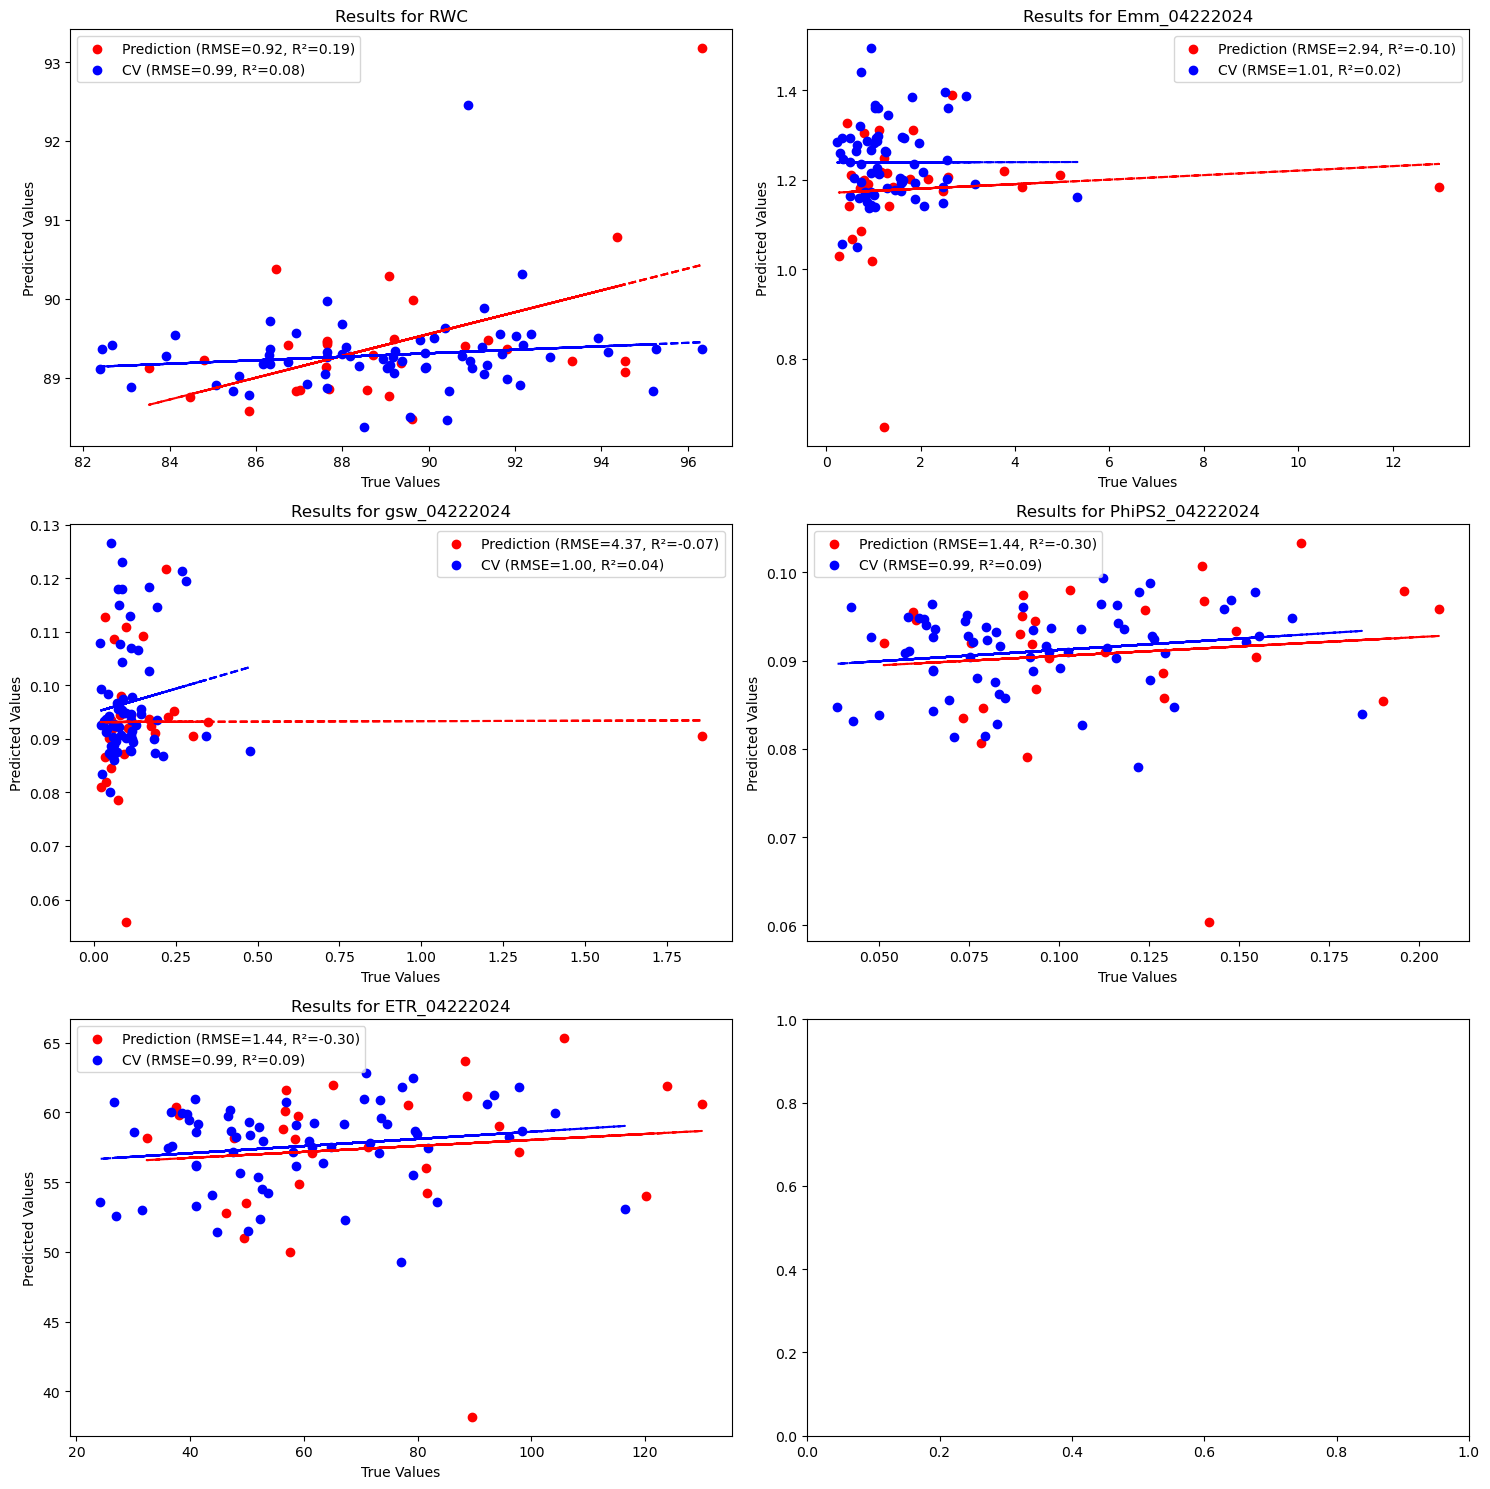

In [38]:
analysis4 = SpectralAnalysis('Final_april_22_24.xlsx','SVR')
analysis4.preprocess_data()
analysis4.fit_model()
analysis4.evaluate_model()
analysis4.plot_results()

Model type: RF
Training Random Forest for RWC
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for RWC: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best score for RWC: -0.040772209503130555
Training Random Forest for Emm_04222024
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for Emm_04222024: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best score for Emm_04222024: -0.5977346736118412
Training Random Forest for gsw_04222024
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for gsw_04222024: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best score for gsw_04222024: -0.6115747088337999
Training Random Forest for PhiPS2_04222024
Fitting 10 folds

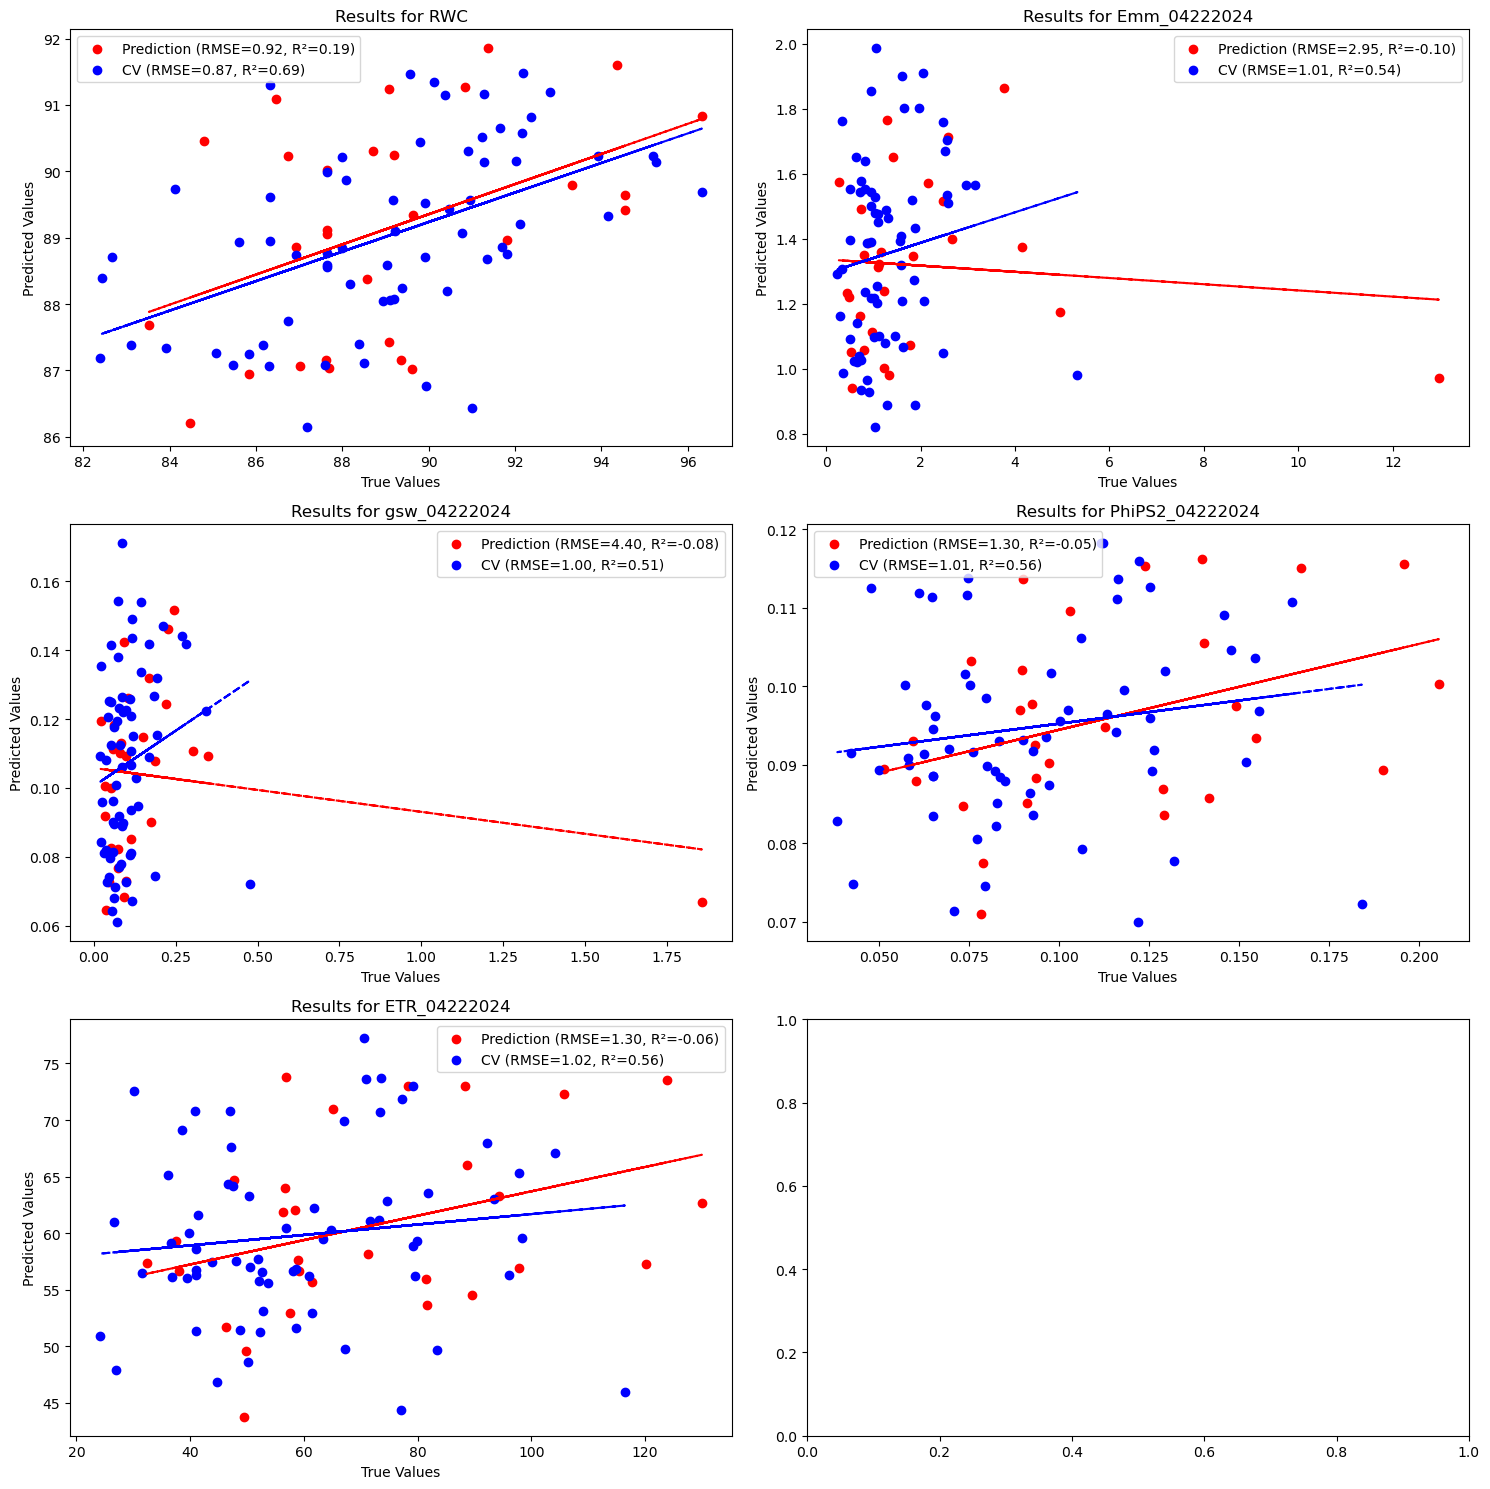

In [43]:
analysis5 = SpectralAnalysis('Final_april_22_24.xlsx','RF')
analysis5.preprocess_data()
analysis5.fit_model()
analysis5.evaluate_model()
analysis5.plot_results()

In [28]:
m=analysis4.models['RWC']
len(cross_val_predict(m, analysis4.X_train, analysis4.y_train['ETR_04222024'], cv=10))

67

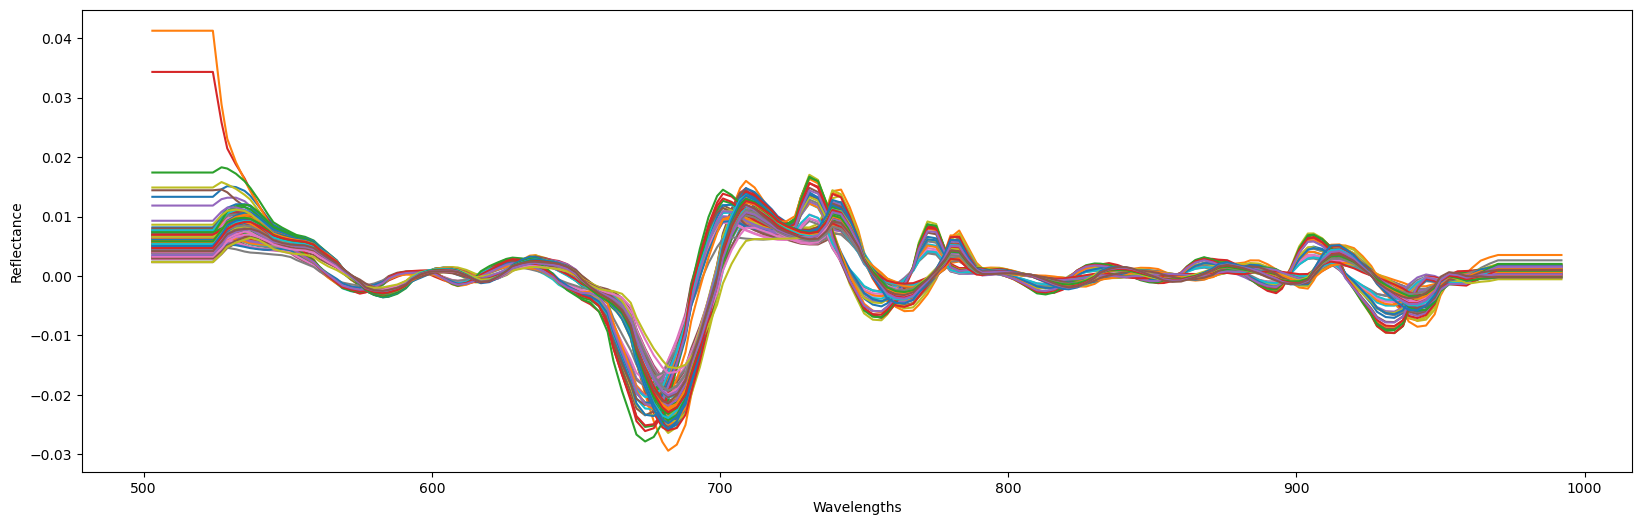

In [129]:
viz(analysis.reflectance_centered,'')

In [65]:
viz(analysis.reflectance_centered2,'')

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

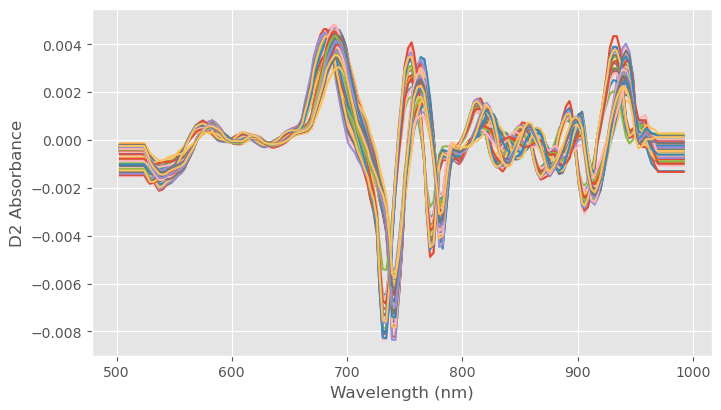

In [121]:
wl=analysis.reflectance.columns
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, analysis.reflectance_centered2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [68]:
analysis.reflectance.columns

Index([503, 506, 508, 511, 514, 516, 519, 522, 524, 527,
       ...
       967, 970, 972, 975, 978, 981, 983, 986, 989, 992],
      dtype='object', length=181)

In [74]:
analysis.reflectance_centered2

array([[-0.00031558, -0.00031558, -0.00031558, ..., -0.00078946,
        -0.00078946, -0.00078946],
       [-0.00049932, -0.00049932, -0.00049932, ..., -0.0013029 ,
        -0.0013029 , -0.0013029 ],
       [-0.00040237, -0.00040237, -0.00040237, ..., -0.00063818,
        -0.00063818, -0.00063818],
       ...,
       [-0.00027721, -0.00027721, -0.00027721, ..., -0.00014507,
        -0.00014507, -0.00014507],
       [-0.00020943, -0.00020943, -0.00020943, ..., -0.0001296 ,
        -0.0001296 , -0.0001296 ],
       [-0.00025019, -0.00025019, -0.00025019, ...,  0.00011908,
         0.00011908,  0.00011908]])